<a href="https://colab.research.google.com/github/Amirrezahmi/Test/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
14/14 [==============================] - 8s 168ms/step - loss: 0.0510 - val_loss: 0.0225 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 1s 83ms/step - loss: 0.0250 - val_loss: 0.0219 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 1s 86ms/step - loss: 0.0229 - val_loss: 0.0235 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 2s 127ms/step - loss: 0.0233 - val_loss: 0.0231 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 2s 160ms/step - loss: 0.0228 - val_loss: 0.0229 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 2s 157ms/step - loss: 0.0218 - val_loss: 0.0228 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 2s 171ms/step - loss: 0.0213 - val_loss: 0.0237 - lr: 0.0010
Epoch 8/100
14/14 [==============================] - 2s 158ms/step - loss: 0.0218 - val_loss: 0.0254 - lr: 0.0010
Epoch 9/100
14/14 [==============================] - 1s 99ms/step - loss: 0.0210 - val_los

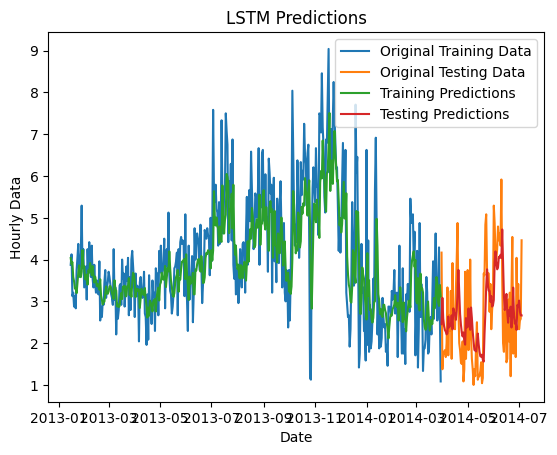

Training Mean Squared Error: 1.0644378082392105
Training Mean Absolute Error: 0.7751581341931315
Testing Mean Squared Error: 1.0236431785208744
Testing Mean Absolute Error: 0.8262978857144332


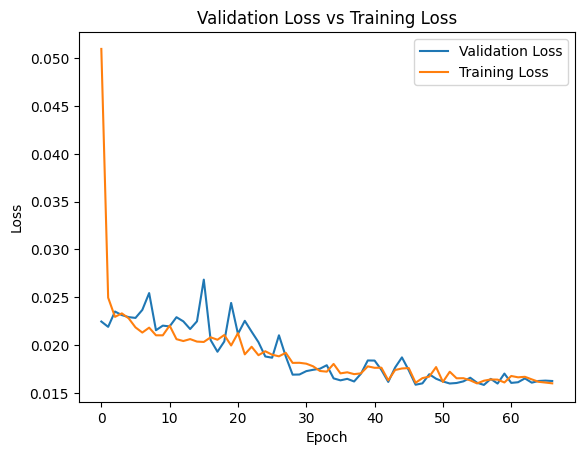

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Step 1: Read the time series data from the txt file
data = pd.read_csv('aa.txt', delimiter='\t', parse_dates=['datetime'], index_col='datetime')

# Step 2: Sort the time series data by datetime
data.sort_index(inplace=True)

# Step 3: Handle missing values
data['data_hourly'].fillna(method='ffill', inplace=True)

# Step 4: Resample the data to a specific frequency
data_resampled = data.resample('D').mean()

# Step 5: Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_resampled[['data_hourly']])

# Step 6: Prepare the data for LSTM with lag features
look_back = 14 # Increase the look-back window for more context

def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i+look_back), 0])
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(data_normalized, look_back)

# Step 7: Reshape the input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 8: Split the data into training and testing sets
train_size = int(0.8 * len(data_normalized))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 9: Build a larger LSTM model with dropout and more units
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Step 10: Implement early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Step 11: Train the LSTM model for 100 epochs with early stopping and learning rate scheduler
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler_callback])

# Step 12: Predict using the LSTM model
y_train_pred = model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred).flatten()
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred).flatten()

# Step 13: Plot the predicted data with original data
plt.plot(data_resampled.index[look_back:train_size + look_back], data_resampled['data_hourly'][look_back:train_size + look_back], label='Original Training Data')
plt.plot(data_resampled.index[train_size + look_back:], data_resampled['data_hourly'][train_size + look_back:], label='Original Testing Data')
plt.plot(data_resampled.index[look_back:train_size + look_back], y_train_pred, label='Training Predictions')
plt.plot(data_resampled.index[train_size + look_back:], y_test_pred, label='Testing Predictions')
plt.xlabel('Date')
plt.ylabel('Hourly Data')
plt.title('LSTM Predictions')
plt.legend(loc='best')
plt.show()

# Step 14: Calculate evaluation metrics
train_mse = ((y_train_pred - data_resampled['data_hourly'][look_back:train_size+look_back])**2).mean()
train_mae = (abs(y_train_pred - data_resampled['data_hourly'][look_back:train_size+look_back])).mean()
test_mse = ((y_test_pred - data_resampled['data_hourly'][train_size+look_back:])**2).mean()
test_mae = (abs(y_test_pred - data_resampled['data_hourly'][train_size+look_back:])).mean()

print("Training Mean Squared Error:", train_mse)
print("Training Mean Absolute Error:", train_mae)
print("Testing Mean Squared Error:", test_mse)
print("Testing Mean Absolute Error:", test_mae)

# Step 15: Plot the validation loss and training loss
val_loss = history.history['val_loss']
train_loss = history.history['loss']

fig, ax = plt.subplots()
ax.plot(val_loss, label='Validation Loss')
ax.plot(train_loss, label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Validation Loss vs Training Loss')
ax.legend()
plt.show()